<a href="https://colab.research.google.com/github/Lariiuki/Especializacao-Deep-Learning/blob/main/Projeto_final_estatistica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Bibliotecas padrão
import os
import gc
from typing import List

# Bibliotecas de terceiros
import kagglehub
import numpy as np
import pandas as pd

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Preparação dos dados

## Carregamento do Dados Agregados

In [3]:
# Download dados agregados
path = kagglehub.dataset_download("huseyincot/amex-agg-data-pickle")

print("Path to dataset files:", path)

100%|██████████| 2.76G/2.76G [02:14<00:00, 22.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/huseyincot/amex-agg-data-pickle/versions/4


In [4]:
os.listdir(path)

['test_agg.pkl', 'train_agg.pkl']

In [5]:
train_path = os.path.join(path, "train_agg.pkl")
test_path  = os.path.join(path, "test_agg.pkl")

train_df = pd.read_pickle(train_path, compression='gzip')
test_df  = pd.read_pickle(test_path, compression='gzip')

In [6]:
print(train_df.shape)
print(test_df.shape)

(458913, 919)
(924621, 918)


In [7]:
# verificando qual coluna tem a mais no train_df
set(train_df.columns) - set(test_df.columns)

{'target'}

Verificando colunas categoricas

In [8]:
# verificando se existe colunas categoricas
train_df.select_dtypes(include=['object', 'category']).columns

Index(['D_63_last', 'D_64_last'], dtype='object')

In [9]:
# verificando quantas categorias existem
train_df[['D_63_last', 'D_64_last']].nunique()

,0
D_63_last,6
D_64_last,4


In [10]:
from sklearn.preprocessing import OneHotEncoder

# Redefining the function locally to apply the fix for 'sparse' parameter
def one_hot_encode(cat_df, encoder=None):
    if encoder is None:
        # Corrected: changed sparse=False to sparse_output=False
        encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
        encoded = encoder.fit_transform(cat_df)
    else:
        encoded = encoder.transform(cat_df)

    encoded_df = pd.DataFrame(
        encoded,
        columns=encoder.get_feature_names_out(cat_df.columns),
        index=cat_df.index
    )
    return encoded_df, encoder

cat_cols = ['D_63_last', 'D_64_last']

train_cat = train_df[cat_cols]
train_cat_enc, encoder = one_hot_encode(train_cat)

In [11]:
print(train_cat.shape)
print(train_cat_enc.shape)

(458913, 2)
(458913, 11)


In [12]:
train_cat_enc.columns

Index(['D_63_last_CL', 'D_63_last_CO', 'D_63_last_CR', 'D_63_last_XL',
       'D_63_last_XM', 'D_63_last_XZ', 'D_64_last_-1', 'D_64_last_O',
       'D_64_last_R', 'D_64_last_U', 'D_64_last_nan'],
      dtype='object')

Verificando NaNs

In [13]:
# separando colunas categoricas de numericas
num_cols = train_df.select_dtypes(include=['float32','float64','float16','int']).columns
cat_cols = train_df.select_dtypes(include=['object','category']).columns

In [14]:
# verificando os nans por tipo de coluna
train_df[num_cols].isna().sum().sort_values(ascending=False).head(20)
train_df[cat_cols].isna().sum().sort_values(ascending=False).head(20)

,0
D_64_last,5279
D_63_last,0


In [15]:
cat_features = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

In [16]:
[col for col in cat_features if col in train_df.columns]

[]

In [17]:
def impute_helper_aggregated(col, cat_cols=List):
    """
    Função segura para imputar valores faltantes no dataset agregado AMEX.

    - Preenche NaNs em colunas categóricas listadas em cat_cols com a moda
    - Preenche NaNs em colunas numéricas com a média
    - Ignora colunas one-hot (0/1)
    """
    convert_dtype = False

    # Converter float16 para float32 para calcular média com segurança
    if col.dtype == 'float16':
        convert_dtype = True
        col = col.astype('float32')

    # Se a coluna é categórica → preencher moda
    if col.name in cat_cols:
        col = col.fillna(col.mode()[0])
    # Se a coluna é numérica → preencher média
    elif col.dtype in ['float16','float32','float64','int']:
        col = col.fillna(col.mean())

    # Converter de volta para float16 se necessário
    if convert_dtype:
        col = col.astype('float16')

    return col

In [18]:
# criar um dataframe de teste
df_test = pd.DataFrame({
    'num_col': [1.0, 2.0, np.nan, 4.0, np.nan],
    'cat_col': ['A', 'B', np.nan, 'B', 'A']
})

cat_cols = ['cat_col']

print("Antes da imputação:")
print(df_test)

Antes da imputação:
   num_col cat_col
0      1.0       A
1      2.0       B
2      NaN     NaN
3      4.0       B
4      NaN       A


In [19]:
# aplicar a função por coluna
df_test = df_test.apply(impute_helper_aggregated, cat_cols=cat_cols)

print("\nDepois da imputação:")
print(df_test)


Depois da imputação:
    num_col cat_col
0  1.000000       A
1  2.000000       B
2  2.333333       A
3  4.000000       B
4  2.333333       A


In [20]:
def impute_columns_aggregated(df, cat_cols=[]):
    """
    Imputa valores faltantes no dataset agregado.
    - Preenche NaNs em colunas categóricas (cat_cols) com moda
    - Preenche NaNs em colunas numéricas com média
    - Ignora colunas one-hot
    """
    # Aplicar função adaptada
    df = df.apply(impute_helper_aggregated, cat_cols=cat_cols)

    return df

In [21]:
def generate_x_y(df_file_path, test=False):

    df = pd.read_pickle(df_file_path, compression='gzip')
    y = None if test else df['target']

    # D_63_last and D_64_last columns are of type 'category', these are the only columns that need to be one-hot encoded
    # the other, original, categorical features are already modified from the aggregate functions
    encoded_df = one_hot_encode(df[['D_63_last', 'D_64_last']])

    # impute with numerical columns with mean() and categorical columns with most common value
    X = impute_columns_aggregated(df.drop(['D_63_last', 'D_64_last'], axis=1) if test else df.drop(['D_63_last', 'D_64_last', 'target'], axis=1))

    del df
    gc.collect()

    # combine new dataframes and sort them to line up when training/predicting
    X = pd.concat([X, encoded_df], axis=1)

    if test:
        return X
    else:
        return (X, y)

In [24]:
sample_df = train_df.sample(50000, random_state=42)  # pega 50k linhas

# separar target
y_sample = sample_df['target']
X_sample = sample_df.drop('target', axis=1)

# imputar numéricas e categóricas
num_cols = X_sample.select_dtypes(include=['float64', 'float32']).columns
cat_cols = ['D_63_last', 'D_64_last']

X_sample[num_cols] = X_sample[num_cols].fillna(X_sample[num_cols].mean())
for col in cat_cols:
    X_sample[col] = X_sample[col].astype('category')
    X_sample[col] = X_sample[col].fillna(X_sample[col].mode()[0])

# one-hot
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded = encoder.fit_transform(X_sample[cat_cols])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(cat_cols), index=X_sample.index)

# combinar
X_sample = pd.concat([X_sample.drop(cat_cols, axis=1), encoded_df], axis=1)


In [25]:
# opcional: pegar apenas uma amostra para análise exploratória
sample_test = test_df.sample(50000, random_state=42)  # ajuste conforme memória

# aplicar mesmo tratamento (imputação + one-hot)
X_test_sample = sample_test.copy()

# colunas numéricas
num_cols = X_test_sample.select_dtypes(include=['float64','float32']).columns
X_test_sample[num_cols] = X_test_sample[num_cols].fillna(X_test_sample[num_cols].mean())

# colunas categóricas
cat_cols = ['D_63_last', 'D_64_last']
for col in cat_cols:
    X_test_sample[col] = X_test_sample[col].astype('category')
    X_test_sample[col] = X_test_sample[col].fillna(X_test_sample[col].mode()[0])

# one-hot (usar o mesmo encoder treinado no treino para consistência)
encoded_test, _ = one_hot_encode(X_test_sample[cat_cols], encoder=encoder)
X_test_sample = pd.concat([X_test_sample.drop(cat_cols, axis=1), encoded_test], axis=1)

In [26]:
X_sample.shape

(50000, 926)

In [27]:
# contagem de NaNs
display(X_sample.isna().sum().sort_values(ascending=False).head(10))

,0
D_87_max,49906
D_87_last,49906
D_87_mean,49906
D_87_min,49906
D_88_last,49740
D_88_max,49740
D_88_mean,49740
D_88_min,49740
D_111_last,49534
D_111_max,49534


In [28]:
X_sample_imputed = X_sample.apply(impute_helper_aggregated, cat_cols=['D_63_last','D_64_last'])

In [29]:
# verificar se ainda tem NaNs
print(X_sample_imputed.isna().sum().sort_values(ascending=False).head(10))

D_64_last_U    0
P_2_mean       0
P_2_std        0
P_2_min        0
P_2_max        0
P_2_last       0
D_39_mean      0
D_39_std       0
D_39_min       0
D_39_max       0
dtype: int64


## Probabilidade e Distribuições

In [30]:
# prefixos dos grupos
var_groups = {
    'D_ - Inadimplência': [c for c in X_sample.columns if c.startswith('D_')],
    'B_ - Saldo': [c for c in X_sample.columns if c.startswith('B_')],
    'S_ - Gastos': [c for c in X_sample.columns if c.startswith('S_')],
    'P_ - Pagamento': [c for c in X_sample.columns if c.startswith('P_')],
    'R_ - Risco': [c for c in X_sample.columns if c.startswith('R_')]
}

# separar por tipo
num_vars_by_group = {}
cat_vars_by_group = {}

for grp, cols in var_groups.items():
    num_vars_by_group[grp] = [c for c in cols if c not in cat_features]
    cat_vars_by_group[grp] = [c for c in cols if c in cat_features]

/tmp/ipython-input-3949582237.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x='Grupo', y='Valor', data=df_summary, palette='pastel')


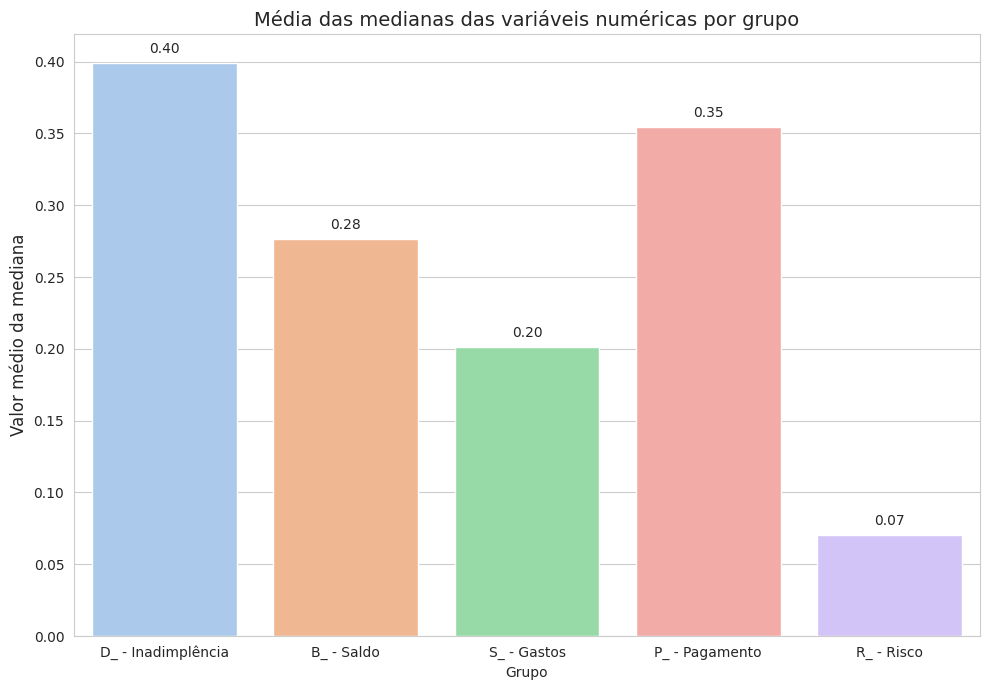

In [36]:
# Mantém estilo mais bonito
sns.set_style("whitegrid")

# Criar dados do gráfico
group_summary = {}
for grp, cols in num_vars_by_group.items():
    group_summary[grp] = X_sample[cols].median().mean()  # média das medianas de cada coluna

# Converter para DataFrame para facilitar plot
df_summary = pd.DataFrame({
    'Grupo': list(group_summary.keys()),
    'Valor': list(group_summary.values())
})

# Plot
plt.figure(figsize=(10,7))
bars = sns.barplot(x='Grupo', y='Valor', data=df_summary, palette='pastel')
plt.title('Média das medianas das variáveis numéricas por grupo', fontsize=14)
plt.ylabel('Valor médio da mediana', fontsize=12)
plt.xticks(rotation=0)

# Adicionar valores acima das barras
for bar in bars.patches:
    height = bar.get_height()
    bars.annotate(f'{height:.2f}',
                  xy=(bar.get_x() + bar.get_width() / 2, height),
                  xytext=(0, 5),  # distância do topo da barra
                  textcoords='offset points',
                  ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

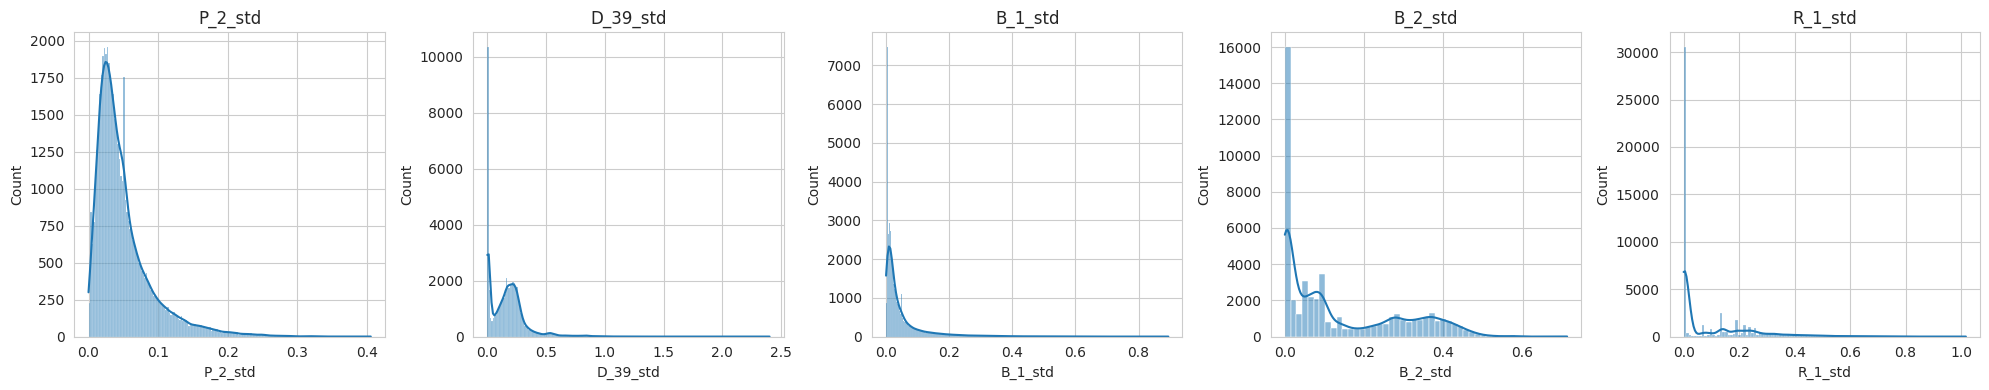

In [37]:
num_cols = X_sample.select_dtypes(include=['float32','float64']).columns[:5]  # as 5 primeiras colunas

# criar uma figura com 1 linha e 5 colunas
fig, axes = plt.subplots(1, len(num_cols), figsize=(20,4))  # largura 20 para 5 gráficos

for ax, col in zip(axes, num_cols):
    sns.histplot(X_sample[col], kde=True, ax=ax)
    ax.set_title(col)

plt.tight_layout()
plt.show()

P_2_str(payment) - Distribuição assimétrica à direita, com grande concentração em valores baixos, pode indicar que os clientes apresentam comportamento de pagamento estável. Mas clientes com valores extremos em P_2_std podem sinalizar dificuldades de liquidez, aumentando o risco de inadimplência futura.

D_29_std(deliquency) - Distribuição altamente concentrada em valores próximos de zero. Pequenos picos secundários indicam subgrupos com histórico de atraso. Cauda longa sugere poucos clientes com histórico severo de inadimplência. Essa variável é particularmente informativa, pois mesmo pequenas variações podem representar diferenças significativas no risco de crédito.

b_1_std(balance) - Forte concentração em valores baixos. Cauda longa associada a clientes com saldos elevados ou comportamento de endividamento persistente. Clientes com altos valores em B_1_std tendem a carregar saldos elevados ao longo do tempo, o que aumenta a exposição ao risco de não pagamento, especialmente em cenários de aumento de juros.

b_2_std(balance) - Distribuição mais espalhada em relação às demais. Indícios de multimodalidade, sugerindo diferentes perfis de uso do crédito. Pode representar desde clientes com uso moderado até clientes com utilização intensiva do limite.

r_1_std(risk) - Extremamente concentrada próxima de zero. Presença de poucos valores muito elevados. Perfil típico de uma variável diretamente associada ao risco. Embora poucos clientes apresentem valores altos, esses casos são justamente os mais relevantes para estratégias de mitigação de risco e priorização de ações de cobrança ou revisão de crédito.

In [38]:
from scipy.stats import shapiro

# teste shapiro
col = 'P_2_std'
stat, p = shapiro(X_sample[col])
print(f'Stat={stat}, p={p}')
if p > 0.05:
    print(f'{col} parece normalmente distribuída')
else:
    print(f'{col} NÃO parece normalmente distribuída')

Stat=0.8115218443671187, p=1.3906435300681602e-113
P_2_std NÃO parece normalmente distribuída


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 50000.
  res = hypotest_fun_out(*samples, **kwds)


O valor da estatística W distante de 1 indica grande desvio da normalidade;

O p-valor extremamente pequeno confirma que a distribuição de P_2_std não segue uma distribuição normal.

Isso confirma exatamente o que já era visível no histograma:

- Forte assimetria à direita;

- Concentração de observações próximas de zero;

- Cauda longa com valores extremos.

/tmp/ipython-input-1512952463.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=y_sample, palette='Set2')


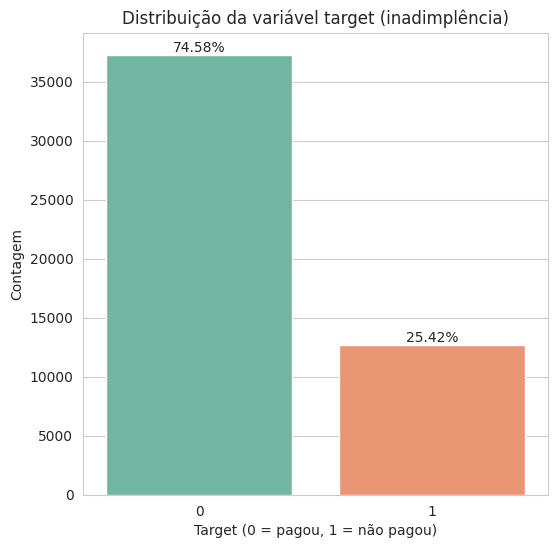

In [39]:
plt.figure(figsize=(6,6))
ax = sns.countplot(x=y_sample, palette='Set2')
plt.title('Distribuição da variável target (inadimplência)')
plt.xlabel('Target (0 = pagou, 1 = não pagou)')
plt.ylabel('Contagem')

# adicionar porcentagens no topo das barras
total = len(y_sample)
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height/total:.2%}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10)

plt.show()

## Teste de hipoteses / ANOVA

**Comparação de médias (t-test)**

Vamos ver se a média de P_2_mean é diferente entre clientes que pagaram e não pagaram:

In [40]:
from scipy.stats import ttest_ind

# separar grupos
grupo_0 = X_sample[y_sample==0]['P_2_mean']
grupo_1 = X_sample[y_sample==1]['P_2_mean']

# teste t
stat, p = ttest_ind(grupo_0, grupo_1, equal_var=False)
print(f"t-statistic={stat:.3f}, p-value={p:.3e}")

if p < 0.05:
    print("Conclusão: Diferença significativa entre os grupos")
else:
    print("Conclusão: Não há diferença significativa entre os grupos")

t-statistic=nan, p-value=nan
Conclusão: Não há diferença significativa entre os grupos


Hipótese nula (H0): as médias de P_2_mean são iguais para clientes que pagam e não pagam.

Hipótese alternativa (H1): as médias são diferentes.

p < 0.05 → rejeita H0 → existe diferença significativa entre os grupos.

“Clientes que atrasam o pagamento têm comportamento médio de gastos diferente em relação aos que pagam em dia.”

**Relação entre categorias (Qui-quadrado)**

Vamos ver se a categoria D_63_last está relacionada com a inadimplência (y_sample):

In [41]:
from scipy.stats import chi2_contingency

# tabela de contingência
tabela = pd.crosstab(sample_df['D_63_last'], y_sample)
print(tabela)

# teste Qui-quadrado
chi2, p, dof, ex = chi2_contingency(tabela)
print(f"Chi2={chi2:.3f}, p-value={p:.3e}")

if p < 0.05:
    print("Conclusão: Existe relação significativa entre a categoria e inadimplência")
else:
    print("Conclusão: Não existe relação significativa")

target         0     1
D_63_last             
CL          2694  1172
CO         27562  9936
CR          6580  1421
XL            49    41
XM           124    46
XZ           279    96
Chi2=338.905, p-value=4.281e-71
Conclusão: Existe relação significativa entre a categoria e inadimplência


H0: categoria D_63_last é independente do atraso de pagamento

H1: existe relação entre categoria e atraso

Se p < 0.05 → a categoria influencia a inadimplência

“Determinadas categorias de comportamento estão associadas a maior risco de inadimplência.”

**ANOVA (>2 grupos)**

Se você tiver uma variável categórica com mais de 2 categorias (ex.: D_64_last) e quiser comparar média de P_2_mean entre os grupos:

In [42]:
from scipy.stats import f_oneway

# separar grupos por categoria usando .loc para indexação segura
grupos = [X_sample.loc[sample_df['D_64_last']==cat, 'P_2_mean'] for cat in sample_df['D_64_last'].unique()]

# Filtrar grupos vazios, pois f_oneway requer que cada grupo tenha pelo menos um dado
grupos_validos = [grupo for grupo in grupos if not grupo.empty]

# Verificar se há pelo menos dois grupos válidos para realizar o teste ANOVA
if len(grupos_validos) >= 2:
    # ANOVA
    stat, p = f_oneway(*grupos_validos)
    print(f"F-statistic={stat:.3f}, p-value={p:.3e}")

    if p < 0.05:
        print("Conclusão: Pelo menos um grupo tem média significativamente diferente")
    else:
        print("Conclusão: Não há diferença significativa entre os grupos")
else:
    print("Não há grupos suficientes com dados para realizar o teste ANOVA.")

F-statistic=nan, p-value=nan
Conclusão: Não há diferença significativa entre os grupos


ANOVA indica se alguma categoria tem média diferente da variável numérica

## Correlação e Regressão

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

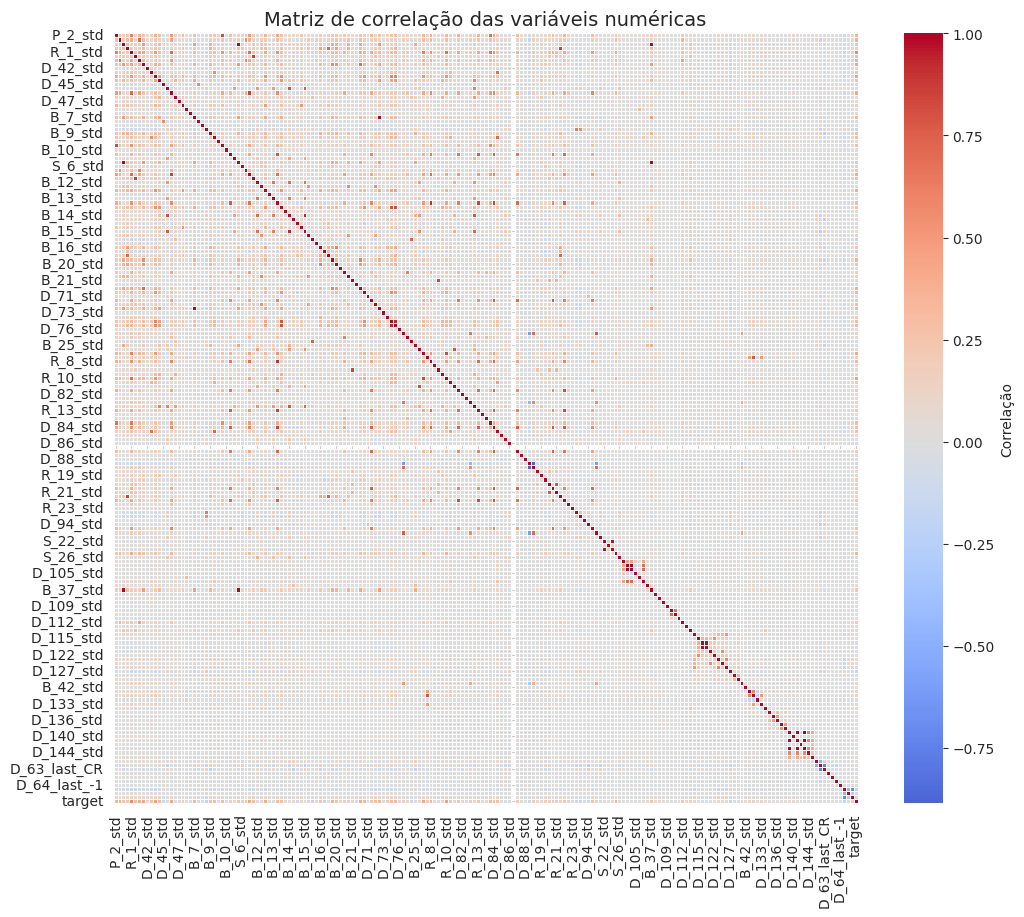

In [58]:
# selecionar apenas variáveis numéricas
num_cols = X_sample_imputed.select_dtypes(include=['float32','float64']).columns

# adicionar target para referência
corr_df = X_sample_imputed[num_cols].copy()
corr_df['target'] = y_sample.values

# matriz de correlação
corr_matrix = corr_df.corr(method='pearson')

# plot
plt.figure(figsize=(12,10))
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    cbar_kws={'label': 'Correlação'}
)
plt.title('Matriz de correlação das variáveis numéricas', fontsize=14)
plt.show()

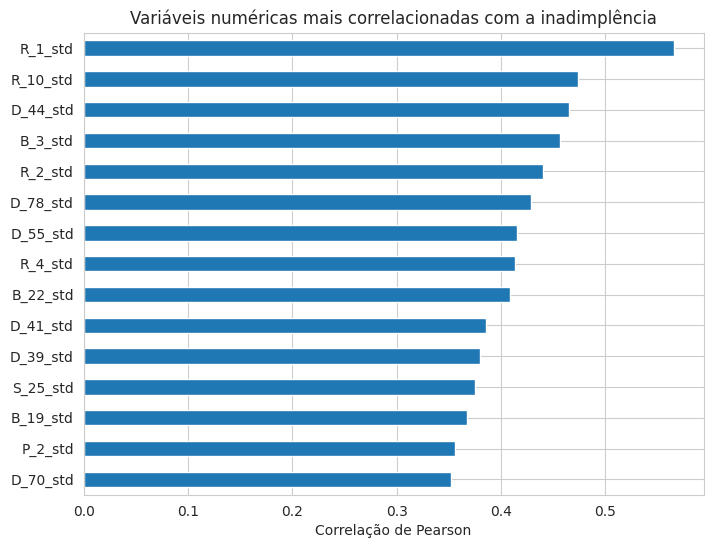

In [59]:
# correlação das variáveis numéricas com o target
corr_target = corr_df.corr()['target'].drop('target')

# pegar as 15 maiores correlações (em valor absoluto)
top_corr = corr_target.abs().sort_values(ascending=False).head(15)

# reorganizar mantendo sinal
top_corr_signed = corr_target[top_corr.index]

# plot
plt.figure(figsize=(8,6))
top_corr_signed.sort_values().plot(
    kind='barh'
)
plt.title('Variáveis numéricas mais correlacionadas com a inadimplência')
plt.xlabel('Correlação de Pearson')
plt.show()

In [44]:
# split treino / validação
# Use X_sample_imputed instead of X_sample, as it's confirmed to have no NaNs
X_train, X_val, y_train, y_val = train_test_split(
    X_sample_imputed, y_sample, test_size=0.2, random_state=42, stratify=y_sample
)

# It's good practice to ensure the data types are consistent and suitable for scikit-learn
# Convert to float32 to avoid potential issues with float16 in some scikit-learn models
# and ensure compatibility while saving memory compared to float64
X_train = X_train.astype(np.float32)
X_val = X_val.astype(np.float32)

# modelo baseline
model = LogisticRegression(
    max_iter=1000,
    solver='lbfgs',
    n_jobs=-1
)

model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, n_jobs=-1)

In [45]:
y_val_pred_proba = model.predict_proba(X_val)[:, 1]

In [46]:
# y_true no formato esperado
y_true_df = pd.DataFrame({
    'target': y_val.values
}, index=y_val.index)

# y_pred no formato esperado
y_pred_df = pd.DataFrame({
    'prediction': y_val_pred_proba
}, index=y_val.index)

In [49]:
def amex_metric(y_true, y_pred):
    labels = np.transpose(np.array([y_true['target'], y_pred['prediction']]))
    labels = labels[labels[:, 1].argsort()[::-1]]
    weights = np.where(labels[:,0]==0, 20, 1)
    cut_vals = np.append( (labels[:,0].cumsum() - labels[:,0].cumsum()[-1] + weights.cumsum())[::20],
                        weights.cumsum()[-1] )

    top_fourty = np.sum(labels[:int(len(labels)*0.04),0]) / np.sum(labels[:,0])

    gini = [0]*len(labels)
    gini = [labels[i,0] * weights[i] for i in range(len(labels))]

    gini = np.array(gini)
    gini = gini.cumsum()
    gini = gini / gini[-1]

    n = len(labels)
    gini = gini - (np.arange(n) + 1) / n

    score = 0.5 * (gini.sum()/float(len(labels)-1) + top_fourty)

    return score

score = amex_metric(y_true_df, y_pred_df)
print(f'AMEX metric: {score:.5f}')

AMEX metric: 0.24589


In [51]:
# Convert probabilities to binary predictions using a threshold (e.g., 0.5)
y_val_pred = (y_val_pred_proba > 0.5).astype(int)

print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.92      0.94      0.93      7458
           1       0.81      0.77      0.79      2542

    accuracy                           0.90     10000
   macro avg       0.87      0.85      0.86     10000
weighted avg       0.89      0.90      0.90     10000



In [53]:
gc.collect()

760